In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tkinter as tk
from PIL import Image, ImageDraw
from tqdm import tqdm


graphics_path = r'C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\acc_graphics'

# Cargar el archivo CSV
df = pd.read_csv(r"C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\datasets\train.csv")


data = np.array(df)

np.random.seed(0)

muestras, columnas = data.shape
print(muestras, columnas)

np.random.shuffle(data) # mezclo para evitar overffitting



data_test = data[40000:, :].T # hago que cada uestra sea una columna y no una fila como antes
Y_test = data_test [0]
X_test = data_test [1:]
mean = np.mean(X_test)
std_dev = np.std(X_test)

# Normalizar usando desviación estándar
X_test = (X_test - mean) / std_dev
# X_test = X_test / 255.

data_train = data[:40000].T # hago que cada muestra sea una columna y no una fila como antes
Y_train = data_train[0] # la col 0 es el label
X_train = data_train[1:]
mean = np.mean(X_train)
std_dev = np.std(X_train)

# Normalizar usando desviación estándar
X_train = (X_train - mean) / std_dev
# X_train = X_train / 255.

print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)

42000 785
(784, 2000)
(2000,)
(784, 40000)
(40000,)


iteracion = 19999 loss = [[9.99976210e-01]
 [4.90232688e-32]
 [8.21319677e-16]
 [9.83927371e-18]
 [2.92610704e-24]
 [3.35167214e-11]
 [2.45025066e-20]
 [6.19080909e-27]
 [3.68861233e-11]
 [1.26282096e-20]]
test: 0.918
train : 0.93665


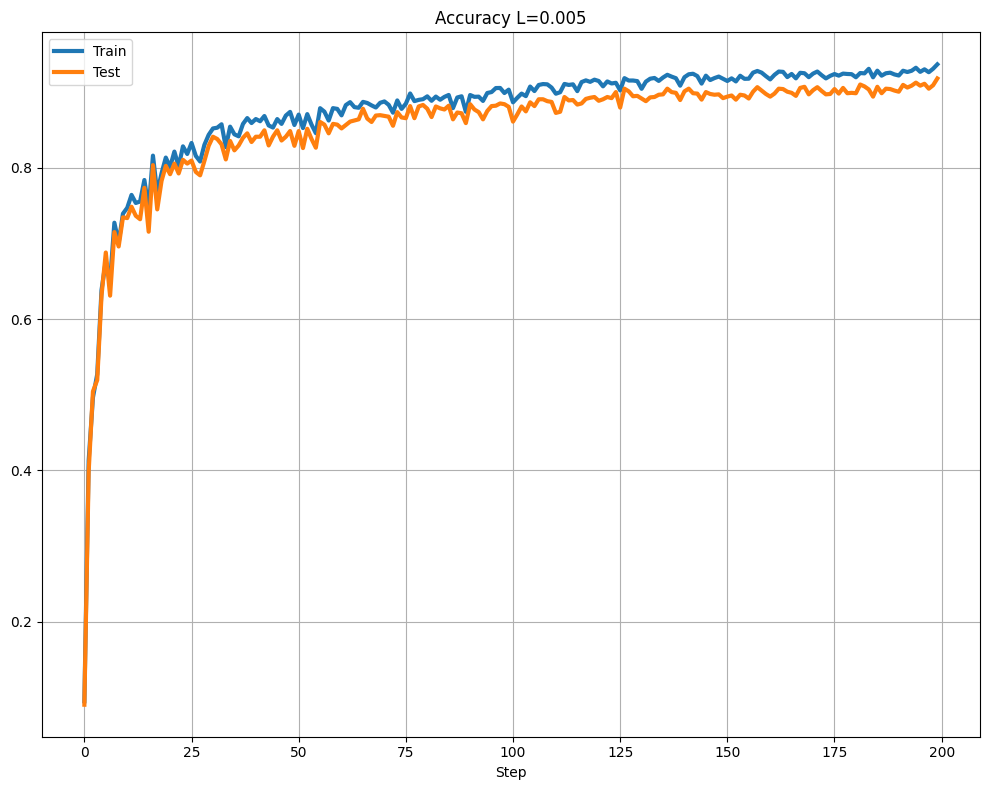

In [22]:

neurons = 256
# Construir red neuronal con pesos y sesgos
# inicializados aleatoriamente
w_hidden = np.random.rand(neurons, 784) - 0.5
w_output = np.random.rand(10, neurons) - 0.5

b_hidden = np.random.rand(neurons, 1) - 0.5
b_output = np.random.rand(10, 1) - 0.5

# Funciones de activación
relu = lambda x: np.maximum(x, 0)
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z))
    return exp_Z / exp_Z.sum(axis=0)

# Ejecutar entradas a través de la red neuronal para obtener salidas predichas
def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden
    A1 = relu(Z1)
    Z2 = w_output @ A1 + b_output
    A2 = softmax(Z2)    
    return Z1, A1, Z2, A2


# Derivadas de las funciones de activación
d_relu = lambda x: x > 0
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

def one_hot_encode(Y):
    one_hot_Y = np.zeros((10, Y.shape[0]))
    one_hot_Y[Y] = 1
    return one_hot_Y

def d_softmax(A2, Y):
    """
    Hay dos casos para la derivada, cuando i es = al valor esperado osea Y, y cuando no lo es 
    """
    dA2_dZ2 = np.zeros_like(A2) # Matriz jacobiana (n x n)
    
    for i in range(A2.shape[0]):
        if i == Y:
            dA2_dZ2[i] =  A2[Y] * (1 - A2[Y])
        else:
            dA2_dZ2[i] =  -A2[i] * A2[Y]
    
    return dA2_dZ2

# Devuelve pendientes para pesos y sesgos
# usando la regla de la cadena
def backward_prop(Z1, A1, Z2, A2, X, Y, W2):
    
    one_hot_Y = one_hot_encode(Y)
    dZ2 = A2 - one_hot_Y
    dC_dW2 = dZ2.dot(A1.T)
    dC_dB2 =  np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * d_relu(Z1)
    dC_dW1 = dZ1.dot(X.T)
    dC_dB1 = np.sum(dZ1, axis=1, keepdims=True)
    

    return dC_dW1, dC_dB1, dC_dW2, dC_dB2

accuracy_train_l = []
accuracy_test_l = []
    
L = 0.005  # La tasa de aprendizaje
iters = 20_000
# Ejecutar descenso de gradiente
for i in range(iters):
    # seleccionar aleatoriamente uno de los datos de entrenamiento
    idx = np.random.choice(X_train.shape[1], 1, replace=False)
    X_sample = X_train[:, idx]
    Y_sample = Y_train[idx]

    # pasar datos seleccionados aleatoriamente a través de la red neuronal
    Z1, A1, Z2, A2 = forward_prop(X_sample)

    # distribuir error a través de la retropropagación
    # y devolver pendientes para pesos y sesgos
    dW1, dB1, dW2, dB2 = backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample, w_output)

    # actualizar pesos y sesgos
    w_hidden -= L * dW1
    b_hidden -= L * dB1
    w_output -= L * dW2
    b_output -= L * dB2
    

    if i % 100 == 0:
        # Calcular precisión del conjunto de prueba
        test_predictions = forward_prop(X_test)[3]
        test_comparisons = np.argmax(test_predictions, axis=0) == Y_test
        accuracy_test = np.mean(test_comparisons)
        accuracy_test_l.append(accuracy_test)

                # Calcular precisión del conjunto de entrenamiento
        train_predictions = forward_prop(X_train)[3]
        train_comparisons = np.argmax(train_predictions, axis=0) == Y_train
        accuracy_train = np.mean(train_comparisons)
        accuracy_train_l.append(accuracy_train)

                # Imprimir la pérdida y la precisión
        loss = np.mean((A2 - one_hot_encode(Y_sample)) ** 2)  # Pérdida cuadrática media
        
    
print(f"iteracion = {i} loss = {(A2 - Y_sample)**2}")
print(F"test: {accuracy_test}")
print(F"train : {accuracy_train}")
accuracy_graphic(L=L, train_l=accuracy_train_l, test_l=accuracy_test_l, neurons = neurons)

In [6]:
# Configuración global
carpeta_guardado = r'\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist' # Cambia esta ruta a tu carpeta donde quieres guardar las imágenes
imagen_contador = 0  # Para dar nombres únicos a las imágenes guardadas

# Crear la ventana de tkinter
class DibujarNumero:
    def __init__(self, root):
        self.root = root
        self.root.title("Dibuja un número")
        
        # Crear un lienzo de 20x20 para dibujar
        self.canvas = tk.Canvas(self.root, width=200, height=200, bg='black')
        self.canvas.grid(row=0, column=0, pady=2, sticky=tk.W, columnspan=2)
        
        # Configurar eventos para el dibujo
        self.canvas.bind("<B1-Motion>", self.dibujar)
        
        # Botón para guardar el dibujo
        self.guardar_btn = tk.Button(self.root, text="Guardar Dibujo", command=self.guardar_dibujo)
        self.guardar_btn.grid(row=1, column=0, pady=2)
        
        # Botón para limpiar el lienzo
        self.limpiar_btn = tk.Button(self.root, text="Limpiar", command=self.limpiar_lienzo)
        self.limpiar_btn.grid(row=1, column=1, pady=2)
        
        # Crear una imagen para dibujar en ella (PIL)
        self.imagen_pil = Image.new("L", (20, 20), 0)  # Fondo blanco
        self.draw = ImageDraw.Draw(self.imagen_pil)
        self.root.protocol("WM_DELETE_WINDOW", self.cerrar_aplicacion)

    def dibujar(self, event):
        # Dibujar un pequeño círculo donde se haga clic
        x, y = event.x, event.y
        r = 4  # Radio del "pincel"
        
        # Dibujar en el canvas de tkinter
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill='white', outline='white')
        
        # Dibujar en la imagen PIL (convertimos coordenadas 200x200 a 20x20)
        self.draw.ellipse((x / 10 - r / 10, y / 10 - r / 10, x / 10 + r / 10, y / 10 + r / 10), fill='white')
    
    def limpiar_lienzo(self):
        # Limpiar el canvas de tkinter
        self.canvas.delete("all")
        
        # Limpiar la imagen PIL
        self.imagen_pil = Image.new("L", (20, 20), 0)  # Fondo blanco
        self.draw = ImageDraw.Draw(self.imagen_pil)
    
    def guardar_dibujo(self):
        global imagen_contador
        
        # Añadir 4 píxeles de margen en cada dirección (crear una imagen de 28x28)
        imagen_28x28 = Image.new("L", (28, 28), 0)  # Crear una nueva imagen 28x28 con fondo blanco
        imagen_28x28.paste(self.imagen_pil, (4, 4))  # Pegar la imagen 20x20 en el centro con 4 píxeles de margen
        
        # Guardar la imagen
        ruta_imagen = os.path.join(carpeta_guardado, f"numero_{imagen_contador}.png")
        imagen_28x28.save(ruta_imagen)
        print(f"Imagen guardada en: {ruta_imagen}")
        
        # Incrementar el contador para la próxima imagen
        imagen_contador += 1
        
        # Limpiar el lienzo después de guardar
        self.limpiar_lienzo()
    def cerrar_aplicacion(self):
        print("Cerrando la aplicación...")
        self.root.destroy()  # Detener el mainloop y cerrar la ventana

# Crear la ventana de tkinter
root = tk.Tk()

# Iniciar la aplicación de dibujo
app = DibujarNumero(root)

# Ejecutar el mainloop de tkinter
root.mainloop()

Cerrando la aplicación...


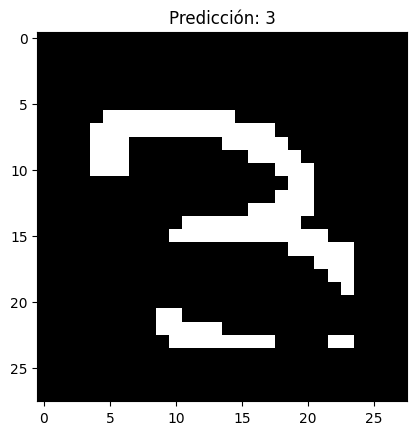

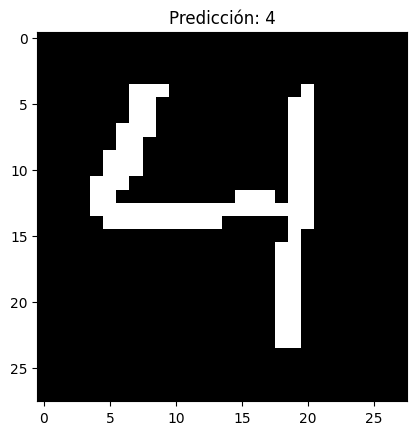

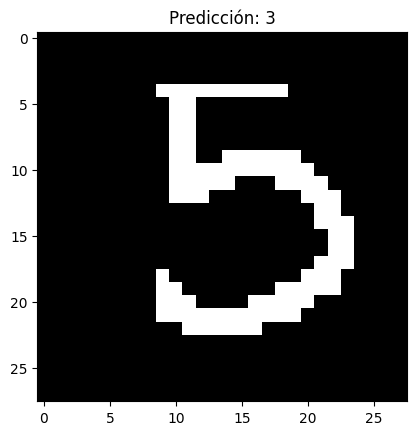

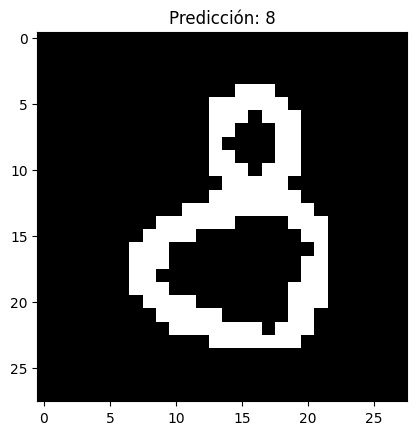

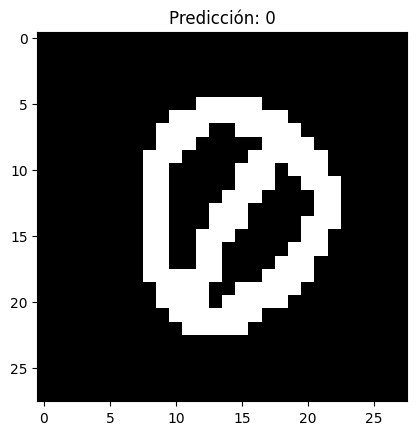

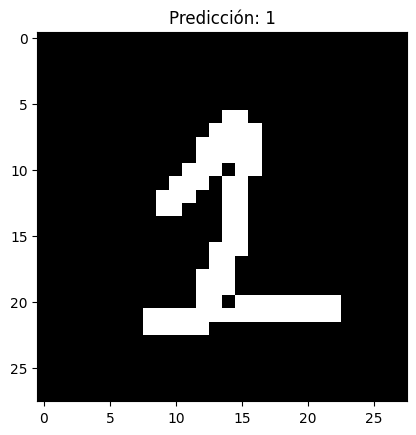

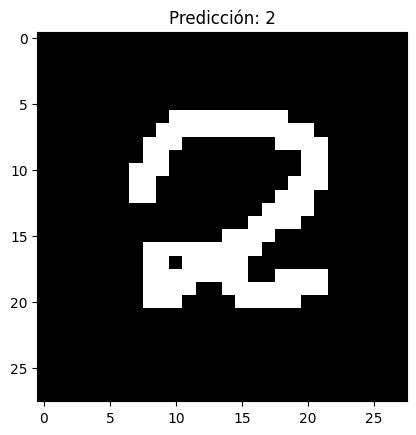

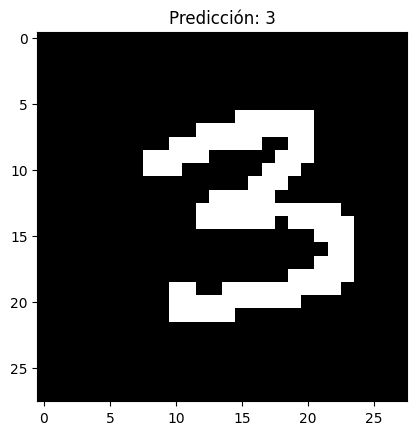

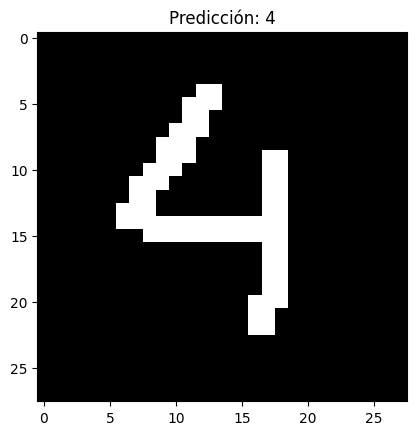

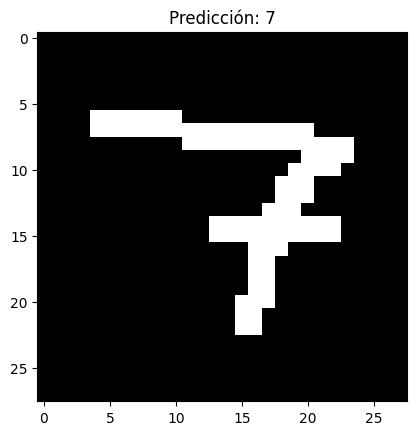

In [31]:
# This function generates predictions using the input data and the trained parameters.
def get_predictions(A2):
    return np.argmax(A2, axis=0)

def make_predictions(X):
    _, _, _, A2 = forward_prop(X)
    predictions = get_predictions(A2)
    return predictions

# Función para procesar una imagen
def procesar_imagen(ruta_imagen):
    # Cargar la imagen
    img = Image.open(ruta_imagen)
    
    # Convertir a escala de grises
    img = img.convert('L')
    
    # Redimensionar a 28x28 píxeles
    img = img.resize((28, 28))
    
    # Convertir la imagen a un array numpy
    img_array = np.array(img)
    
    # Invierte los colores restandle el valor original a 255 y se lo asigna osea si es blanco (255) y se lo restas a 255 entonces te queda negro
    # img_array = 255 - img_array
    
    # Escalar los valores de los píxeles entre 0 y 1
    img_array = img_array / 255.0
    
    # Aplanar la imagen para que sea un vector de 784 dimensiones (28x28)
    img_array = img_array.flatten()
    
    # Convertir a formato adecuado para el modelo (1 imagen)
    return img_array.reshape(1, -1)

# Función para mostrar la imagen junto con su predicción
def mostrar_imagen_con_prediccion(img_array, prediccion):
    # Convertir el array plano de 784 de vuelta a una matriz 28x28
    img_reshaped = img_array.reshape(28, 28)
    
    # Mostrar la imagen usando matplotlib
    plt.title(f'Predicción: {prediccion}')
    plt.imshow(img_reshaped, cmap='gray')
    plt.show()

# Ruta de la carpeta con las imágenes
carpeta_imagenes = r'\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist'

# Obtener una lista de todos los archivos en la carpeta
imagenes = [f for f in os.listdir(carpeta_imagenes) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Recorrer cada imagen en la carpeta
for imagen_nombre in imagenes:
    ruta_imagen = os.path.join(carpeta_imagenes, imagen_nombre)
    
    # Procesar la imagen
    imagen_procesada = procesar_imagen(ruta_imagen)
    
    # Realizar la predicción con el modelo entrenado
    prediccion = make_predictions(imagen_procesada.T)
    
    # Mostrar la imagen con su predicción
    mostrar_imagen_con_prediccion(imagen_procesada, prediccion[0])



100%|██████████| 20000/20000 [02:27<00:00, 136.00it/s]


test: 0.898  train : 0.934


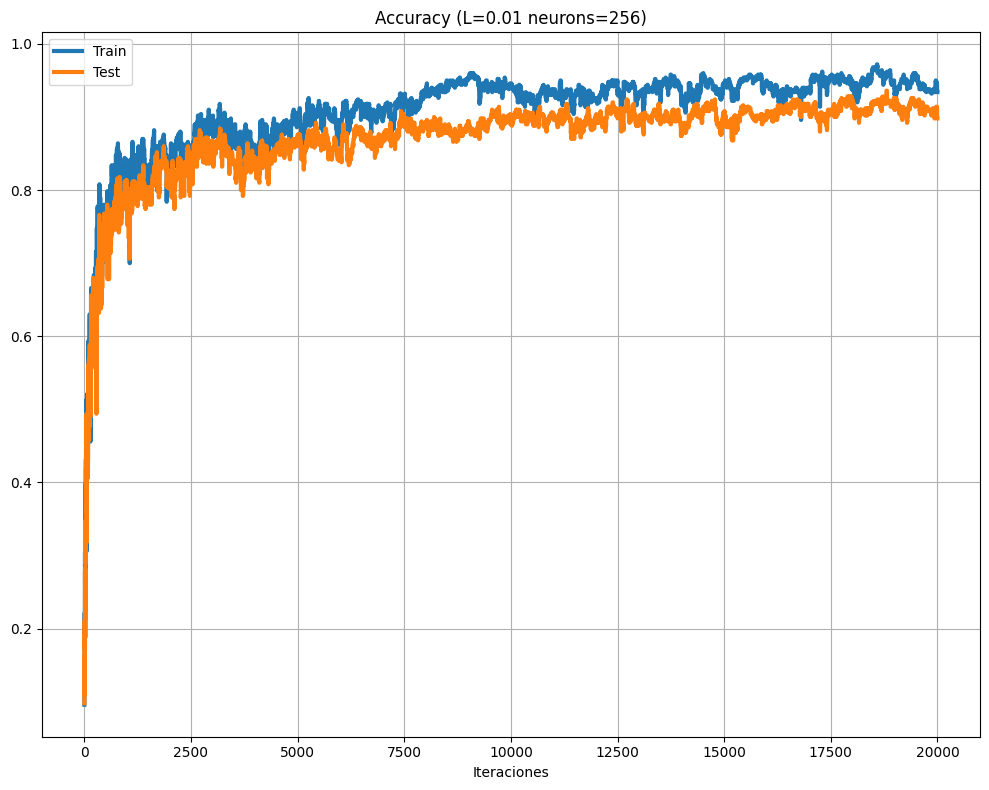

In [39]:
class NeuralNetwork:
    def __init__(self, neurons, learning_rate, iterations):
        self.neurons = neurons
        self.learning_rate = learning_rate
        self.iterations = iterations
        
        # Inicializar pesos y sesgos
        self.w_hidden = np.random.rand(self.neurons, 784) - 0.5
        self.w_output = np.random.rand(10, self.neurons) - 0.5
        self.b_hidden = np.random.rand(self.neurons, 1) - 0.5
        self.b_output = np.random.rand(10, 1) - 0.5

        self.accuracy_train_l = []
        self.accuracy_test_l = []
        
        subset_size = 500
        
        self.X_train_subset = X_train[:, 0:subset_size]
        self.Y_train_subset = Y_train[0:subset_size]
        self.X_test_subset = X_test[:, 0:subset_size]
        self.Y_test_subset = Y_test[0:subset_size]

    # Funciones de activación
    def relu(self, x):
        return np.maximum(x, 0)

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z))
        return exp_Z / exp_Z.sum(axis=0)

    def forward_prop(self, X):
        Z1 = self.w_hidden @ X + self.b_hidden
        A1 = self.relu(Z1)
        Z2 = self.w_output @ A1 + self.b_output
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    def one_hot_encode(self, Y):
        one_hot_Y = np.zeros((10, Y.shape[0]))
        one_hot_Y[Y] = 1
        return one_hot_Y

    def d_relu(self, x):
        return x > 0

    def backward_prop(self, Z1, A1, Z2, A2, X, Y):
        one_hot_Y = self.one_hot_encode(Y)
        dC_dZ2 = A2 - one_hot_Y
        
        dC_dW2 = dC_dZ2.dot(A1.T)
        dC_dB2 = np.sum(dC_dZ2, axis=1, keepdims=True)
        
        dC_Z1 = self.w_output.T.dot(dC_dZ2) * self.d_relu(Z1)
        
        dC_dW1 = dC_Z1.dot(X.T)
        dC_dB1 = np.sum(dC_Z1, axis=1, keepdims=True)
        return dC_dW1, dC_dB1, dC_dW2, dC_dB2

    def train(self, X_train, Y_train, X_test, Y_test):
        for i in tqdm(range(self.iterations)):
            # seleccionar aleatoriamente uno de los datos de entrenamiento
            idx = np.random.choice(X_train.shape[1], 1, replace=False)
            X_sample = X_train[:, idx]
            Y_sample = Y_train[idx]

            # pasar datos seleccionados aleatoriamente a través de la red neuronal
            Z1, A1, Z2, A2 = self.forward_prop(X_sample)

            # distribuir error a través de la retropropagación
            dW1, dB1, dW2, dB2 = self.backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample)

            # actualizar pesos y sesgos
            self.w_hidden -= self.learning_rate * dW1
            self.b_hidden -= self.learning_rate * dB1
            self.w_output -= self.learning_rate * dW2
            self.b_output -= self.learning_rate * dB2
            

            # Calcular precisión del conjunto de prueba
            test_predictions = self.forward_prop(self.X_test_subset)[3]
            test_comparisons = np.argmax(test_predictions, axis=0) == self.Y_test_subset
            accuracy_test = np.mean(test_comparisons)
            self.accuracy_test_l.append(accuracy_test)
                
            # Calcular precisión del conjunto de entrenamiento
            train_predictions = self.forward_prop(self.X_train_subset)[3]
            train_comparisons = np.argmax(train_predictions, axis=0) == self.Y_train_subset
            accuracy_train = np.mean(train_comparisons)
            self.accuracy_train_l.append(accuracy_train)

                # Imprimir la pérdida y la precisión
            loss = np.mean((A2 - self.one_hot_encode(Y_sample)) ** 2)  # Pérdida cuadrática media
                
        print(F"test: {accuracy_test}  train : {accuracy_train}")
        self.accuracy_graphic(self.learning_rate, self.accuracy_train_l, self.accuracy_test_l, self.neurons)

    def accuracy_graphic(self, L, train_l, test_l, neurons):
        iters = self.iterations
        fmt_train = {
            'color': 'tab:blue',
            'ls': 'solid',
            'lw': 3,
        }
        fmt_test = {
            'color': 'tab:orange',
            'ls': 'solid',
            'lw': 3,
        }

        fig, (ax) = plt.subplots(1, 1, figsize=(10, 8))
        ax.plot(train_l, label='Train', **fmt_train)
        ax.plot(test_l, label='Test', **fmt_test)

        ax.grid(which='both')
        ax.legend()
        ax.set_title(f'Accuracy ({L=} {neurons=})')
        ax.set_xlabel('Iteraciones')

        fig.tight_layout()
        plt.savefig( os.path.join(graphics_path, f"accuracy_{L=}_{iters=}_{neurons=}.png"))
        plt.show()


# Ejemplo de uso
iters = 20_000
L = 0.01
neurons = 256


nn = NeuralNetwork(neurons, L, iters)
nn.train(X_train, Y_train, X_test, Y_test)

In [33]:
from PIL import Image, ImageDraw, ImageTk, ImageFilter

carpeta_guardado = r'\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist' # Cambia esta ruta a tu carpeta donde quieres guardar las imágenes
imagen_contador = 0  # Para dar nombres únicos a las imágenes guardadas

class DibujarNumero:
    def __init__(self, root):
        self.root = root
        self.root.title("Dibuja un número")
        
        # Crear un lienzo de 200x200 para dibujar
        self.canvas = tk.Canvas(self.root, width=200, height=200, bg='black')
        self.canvas.grid(row=0, column=0, pady=2, sticky=tk.W, columnspan=2)
        
        # asocia el boton izquierdo de mouse, para el evento dibujar
        self.canvas.bind("<B1-Motion>", self.dibujar)
        
        # muestra el texto con la prediccion actual
        self.prediccion_label = tk.Label(self.root, text="Predicción: -", font=("Helvetica", 14))
        self.prediccion_label.grid(row=2, column=0, columnspan=2, pady=5) # defino en que parte de la ventana se ubica
        
        # creo un boton para guardar la imagen llamando a la funcion guardar
        self.guardar_btn = tk.Button(self.root, text = "Guardar", command = self.guardar)
        self.guardar_btn.grid(row=1, column=0, pady=2) # defino en que parte de la ventana se ubica
        
        # creo el boton para borrar el dibujo en ventana
        self.limpiar_btn = tk.Button(self.root, text="Limpiar", command=self.limpiar_lienzo)
        self.limpiar_btn.grid(row=1, column=1, pady=2) # defino en que parte de la ventana se ubica
    
        # creo una imagen para dibujar en ella (PIL)
        self.imagen_pil = Image.new("L", (20, 20), 0)  # 20x20 con fondo negro
        self.draw = ImageDraw.Draw(self.imagen_pil)
        self.root.protocol("WM_DELETE_WINDOW", self.cerrar_aplicacion) # para que termine el proceso al cerrar la ventana
    
    # funcion que devuelve el valor de A2 mas alto en axis = 0 osea por columna
    def get_predictions(self, A2):
        return np.argmax(A2, axis=0) 

    def make_predictions(self, X):
        _, _, _, A2 = nn.forward_prop(X)
        predictions = self.get_predictions(A2)
        return predictions

    def dibujar(self, event):
        # Dibujar un pequeño círculo donde se haga clic
        x, y = event.x, event.y
        r = 4  # radio del pincel
        
        
        self.draw.ellipse((x / 10 - r / 10, y / 10 - r / 10, x / 10 + r / 10, y / 10 + r / 10), fill='white') # dibuja un circulo en donde se hizo click

                
        self.actualizar_canvas()

        # Preprocesar la imagen para el modelo
        imagen_28x28 = Image.new("L", (28, 28), 0)  # Crear una nueva imagen 28x28 con fondo negro
        imagen_28x28.paste(self.imagen_pil, (4, 4))  # Pegar la imagen 20x20 en el centro con 4 píxeles de margen

        imagen_array = np.array(imagen_28x28)  # Convertir la imagen a un array
        imagen_array = imagen_array.reshape(-1, 1)  # Cambiar la forma a (784, 1) para un modelo típico
        imagen_array = imagen_array / 255.0  # Normalizar 

        # Hacer la predicción
        prediccion = self.make_predictions(imagen_array)

        # Actualizar la etiqueta de predicción
        self.prediccion_label.config(text=f"Predicción: {prediccion[0]}")
        
    
    def limpiar_lienzo(self):
        # Limpiar el canvas de tkinter
        self.canvas.delete("all")
        
        # Limpiar la imagen PIL
        self.imagen_pil = Image.new("L", (20, 20), 0)  # Fondo blanco
        self.draw = ImageDraw.Draw(self.imagen_pil)
        
        self.prediccion_label.config(text=f"Predicción: -")
    def actualizar_canvas(self):
        # Crear una versión ampliada de la imagen para mostrar en el canvas
        imagen_ampliada = self.imagen_pil.resize((200, 200), Image.Resampling.NEAREST)
        self.image_tk = ImageTk.PhotoImage(imagen_ampliada)
        self.canvas.create_image(0, 0, anchor=tk.NW, image=self.image_tk)
        
    def guardar(self):
        global imagen_contador

        # Añadir 4 píxeles de margen en cada dirección (crear una imagen de 28x28)
        imagen_28x28 = Image.new("L", (28, 28), 0)  # Crear una nueva imagen 28x28 con fondo negro
        imagen_28x28.paste(self.imagen_pil, (4, 4))  # Pegar la imagen 20x20 en el centro con 4 píxeles de margen
        
        # Guardar la imagen
        ruta_imagen = os.path.join(carpeta_guardado, f"numero_{imagen_contador}.png")
        imagen_28x28.save(ruta_imagen)
        print(f"Imagen guardada en: {ruta_imagen}")
        
        # Incrementar el contador para la próxima imagen
        imagen_contador += 1
                
    def cerrar_aplicacion(self):
        print("Cerrando la aplicación...")
        self.root.destroy()  # Detener el mainloop y cerrar la ventana

# Crear la ventana de tkinter
root = tk.Tk()

# Iniciar la aplicación de dibujo
app = DibujarNumero(root)

# Ejecutar el mainloop de tkinter
root.mainloop()

Cerrando la aplicación...


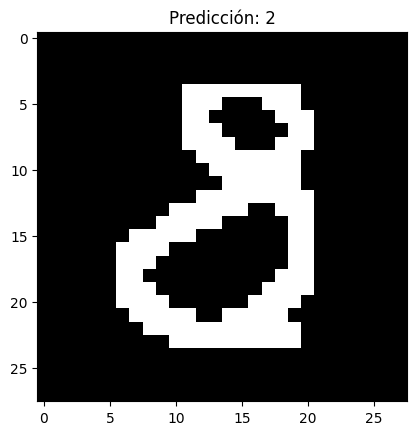

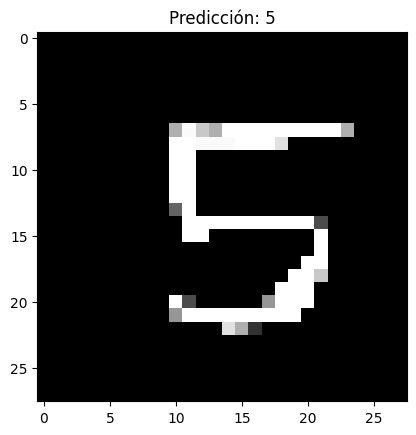

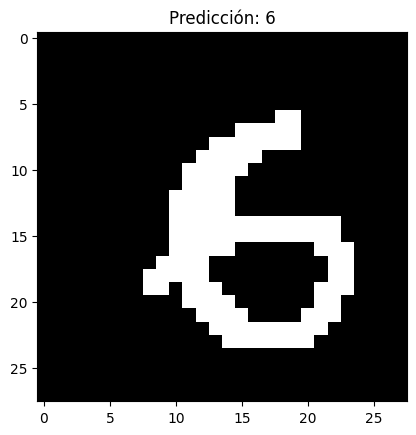

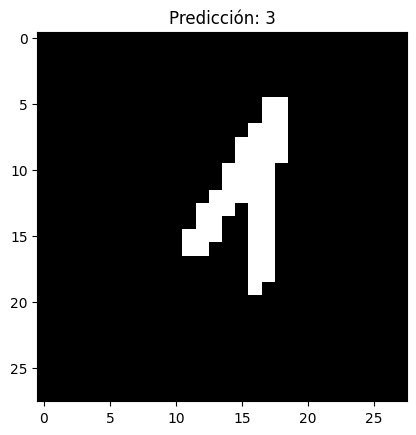

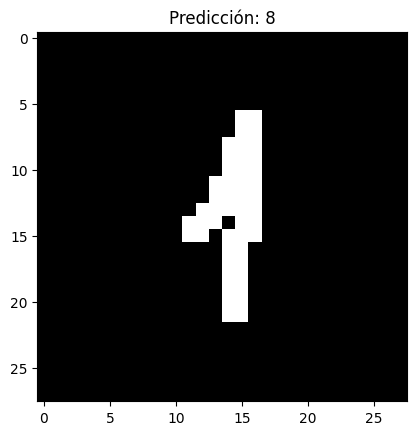

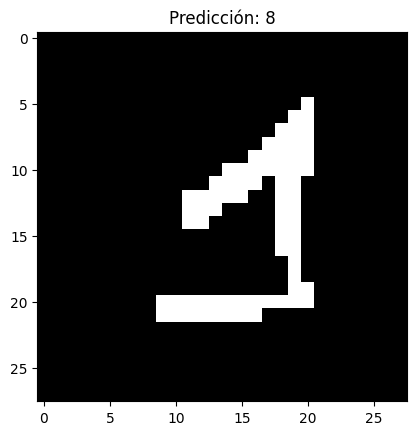

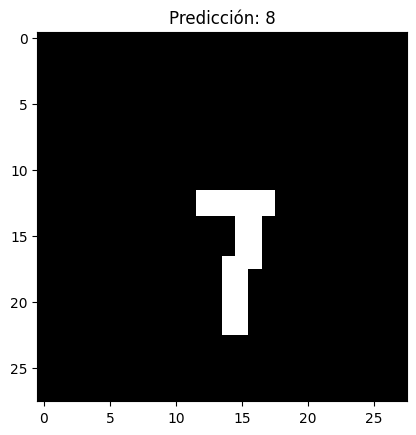

In [31]:
# This function generates predictions using the input data and the trained parameters.
def get_predictions(A2):
    return np.argmax(A2, axis=0)

def make_predictions(X):
    _, _, _, A2 = nn.forward_prop(X)
    predictions = get_predictions(A2)
    return predictions

# Función para procesar una imagen
def procesar_imagen(ruta_imagen):
    # Cargar la imagen
    img = Image.open(ruta_imagen)
    
    # Convertir a escala de grises
    img = img.convert('L')
    
    # Redimensionar a 28x28 píxeles
    img = img.resize((28, 28))
    
    # Convertir la imagen a un array numpy
    img_array = np.array(img)
    
    # Invierte los colores restandle el valor original a 255 y se lo asigna osea si es blanco (255) y se lo restas a 255 entonces te queda negro
    # img_array = 255 - img_array
    
    # Escalar los valores de los píxeles entre 0 y 1
    img_array = img_array / 255.0
    
    # Aplanar la imagen para que sea un vector de 784 dimensiones (28x28)
    img_array = img_array.flatten()
    
    # Convertir a formato adecuado para el modelo (1 imagen)
    return img_array.reshape(1, -1)

# Función para mostrar la imagen junto con su predicción
def mostrar_imagen_con_prediccion(img_array, prediccion):
    # Convertir el array plano de 784 de vuelta a una matriz 28x28
    img_reshaped = img_array.reshape(28, 28)
    
    # Mostrar la imagen usando matplotlib
    plt.title(f'Predicción: {prediccion}')
    plt.imshow(img_reshaped, cmap='gray')
    plt.show()

# Ruta de la carpeta con las imágenes
carpeta_imagenes = r'\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist'

# Obtener una lista de todos los archivos en la carpeta
imagenes = [f for f in os.listdir(carpeta_imagenes) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Recorrer cada imagen en la carpeta
for imagen_nombre in imagenes:
    ruta_imagen = os.path.join(carpeta_imagenes, imagen_nombre)
    
    # Procesar la imagen
    imagen_procesada = procesar_imagen(ruta_imagen)
    
    # Realizar la predicción con el modelo entrenado
    prediccion = make_predictions(imagen_procesada.T)
    
    # Mostrar la imagen con su predicción
    mostrar_imagen_con_prediccion(imagen_procesada, prediccion[0])